In [1]:
%matplotlib ipympl

import relative_imports
from spatiotemporal.SEN12MSCRTS import DatasetManager, ImageUtils
from spatiotemporal.torch_datasets.minimal_dataset import CloudHistogramDataset
from tqdm.notebook import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interactive, fixed, interact_manual, AppLayout
import ipywidgets as widgets
from os.path import join
from torch.utils.data import DataLoader

In [2]:
root_dir = '/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS'
cloud_maps_dir = "/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS_cloud_maps"
cloud_histograms_csv = join(cloud_maps_dir, "cloud_histograms.csv")

In [3]:
dataset_manager = DatasetManager(
    root_dir=root_dir,
    cloud_maps_dir=cloud_maps_dir,
    cloud_probability_threshold=0.6
)

# dataset_manager.load_dataset()
# dataset_manager.save_to_file()
dataset_manager.load_from_file()

# Example

In [4]:
utils = dataset_manager.utils

In [5]:
# These histogram bin values are used to calculate cloud cover percentages for different cloud probability thresholds

# bins = dataset_manager.cloud_probability_bins
# left_bin_edges = bins[:-1]
# right_bin_edges = bins[1:]

# bins

In [6]:
index = dataset_manager.data.index[121902]
index

('ROIs1868', 142, 191, 12)

In [7]:
s2_image = utils.read_tif(dataset_manager.data.loc[index, "S2"])
s2_image.shape, s2_image.dtype, s2_image.min(), s2_image.max()

((13, 256, 256), dtype('uint16'), 0, 8454)

In [8]:
novalue_mask = ~(s2_image[dataset_manager.cloud_detector.MODEL_BAND_IDS] != 0).prod(axis=0, dtype=bool)
novalue_mask.shape, novalue_mask.sum()

((256, 256), 24345)

In [9]:
original_cloud_detector = super(type(dataset_manager.cloud_detector), dataset_manager.cloud_detector)

cloud_map = original_cloud_detector.get_cloud_probability_maps(
    dataset_manager.cloud_detector.prepare_for_cloud_detector(s2_image)
)

cloud_map.max(), cloud_map.shape

(0.9988432203929534, (256, 256))

In [10]:
cloud_map = np.rint(cloud_map * 100).astype(np.uint8)
cloud_map.max()

100

In [11]:
cloud_map[novalue_mask] = 255
cloud_map.max()

255

In [12]:
cloud_map = cloud_map[np.newaxis, ...]
cloud_map.shape, cloud_map.dtype

((1, 256, 256), dtype('uint8'))

Now check if the dataset function does the same thing:

In [13]:
cloud_map_from_wrapper = dataset_manager.cloud_detector.get_cloud_probability_maps(s2_image)
(cloud_map == cloud_map_from_wrapper).all()

True

In [14]:
cloud_map_from_dataset = utils.get_cloud_map(
    index=index,
    try_load=False,
    overwrite=False
)
(cloud_map == cloud_map_from_dataset).all()

True

Also create a thresholded and dilated binary cloud mask

In [15]:
cloud_mask = dataset_manager.cloud_detector.get_mask_from_prob(cloud_map, threshold=0.6)
cloud_mask.shape

(1, 256, 256)

In [16]:
(cloud_mask == 1).mean(), (cloud_mask == 0).mean(), (cloud_mask == 255).mean()

(0.269317626953125, 0.3507080078125, 0.379974365234375)

In [17]:
with plt.ioff():
    fig_0, ax_0 = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), tight_layout=True)

In [18]:
ax_0[0].imshow(utils.bands_last(utils.rescale_s2(s2_image, clip=True)[[3, 2, 1]]))
ax_0[0].set_title("S2 image")
ax_0[0].set_axis_off()

ax_0[1].imshow(cloud_map[0], vmin=0, vmax=100)
ax_0[1].set_title("Cloud map")
ax_0[1].set_axis_off()

ax_0[2].imshow(cloud_mask[0], vmax=2)
ax_0[2].set_title(f"Cloud mask for threshold {dataset_manager.cloud_probability_threshold:.2f}")
ax_0[2].set_axis_off()

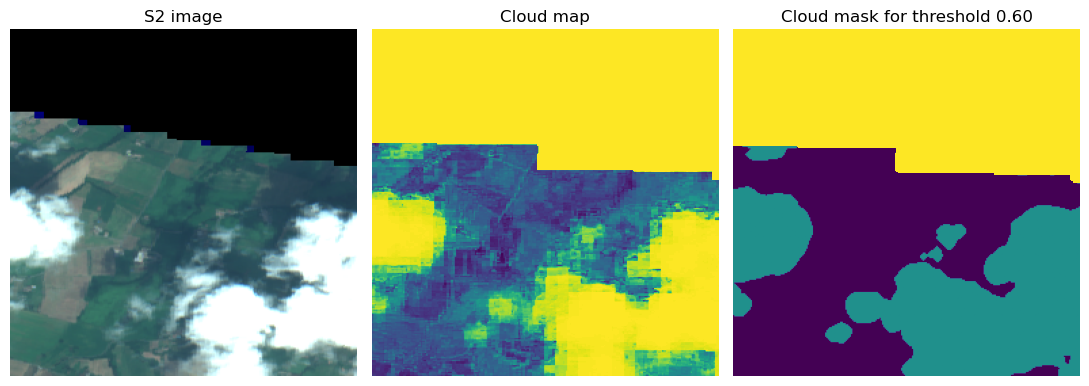

In [19]:
display(fig_0)

In [20]:
plt.close(fig_0)

# Decide how to store cloud masks

Let us measure the execution time for cloud map calculation, cloud map thresholding, and for loading a precomputed cloud map from drive

In [20]:
%%timeit -r 5 -n 100

dataset_manager.cloud_detector.get_cloud_probability_maps(
    utils.prepare_for_cloud_detector(s2_image)
)

In [21]:
%%timeit -r 5 -n 100
dataset_manager.cloud_detector.get_mask_from_prob(
    cloud_map,
    threshold=0.2
)

In [23]:
%%timeit -r 5 -n 100
cloud_map < (dataset_manager.cloud_probability_threshold)

In [24]:
%%timeit -r 5 -n 100
cloud_map = utils.read_tif(dataset_manager.data.loc[index, "S2CLOUDMAP"])

Colclusion: compared to loading cloud maps from drive, the time for running the `get_mask_from_prob()` function is not so large, even though it involves convolution and dilation operations. We can probably run it on the fly after we load the cloud map.

Therefore, we choose to store the cloud maps in original format, without blur and dilation.

### Investigate the influence of threshold

In [21]:
with plt.ioff():
    fig_1, axs_1 = plt.subplots(figsize=(14, 5), ncols=3, subplot_kw={"aspect": "auto"})

In [23]:
cloud_probability_histogram = np.bincount(cloud_map[0, ~novalue_mask], minlength=101)
cloud_probability_histogram = cloud_probability_histogram / cloud_probability_histogram.sum()
cloud_probability_bins = np.arange(len(cloud_probability_histogram)) / 100.0

axs_1[0].set_title("Cloud probability map")
axs_1[0].set_axis_off()
axs_1[0].imshow(
    cloud_map[0],
    vmin=0,
    vmax=100
)

axs_1[1].set_title(f"Cloud mask for threshold {dataset_manager.cloud_probability_threshold:.2f}")
axs_1[1].set_axis_off()
cloud_mask_image = axs_1[1].imshow(
    cloud_mask[0],
    vmin=0.0, 
    vmax=1.0
)

axs_1[2].set_title("Cloud cover [%]")
axs_1[2].set_xlabel("Cloud probability threshold")
bar_chart = axs_1[2].bar(
    x=cloud_probability_bins, 
    height=cloud_probability_histogram, 
    width=0.01
)

slider_1 = widgets.FloatSlider(
    value=dataset_manager.cloud_probability_threshold,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Cloud probability threshold: ',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="auto")
)

def update_im_1(threshold):
    
    cloud_mask = utils.get_cloud_mask(
        threshold=threshold,
        index=index,
        try_load=True,
        overwrite=True
    )

    # update cloud mask
    axs_1[1].set_title(f"Cloud mask for threshold {threshold:.2f}")
    cloud_mask_image.set_data(cloud_mask[0])
    
    # update bar plot
    _ = [bar.set_color('r') if np.isclose(bin_, threshold) else bar.set_color('b') for bar, bin_ in zip(bar_chart, cloud_probability_bins)]
    
    fig_1.canvas.draw_idle()

slider_1_widget = interactive(update_im_1, threshold=slider_1)

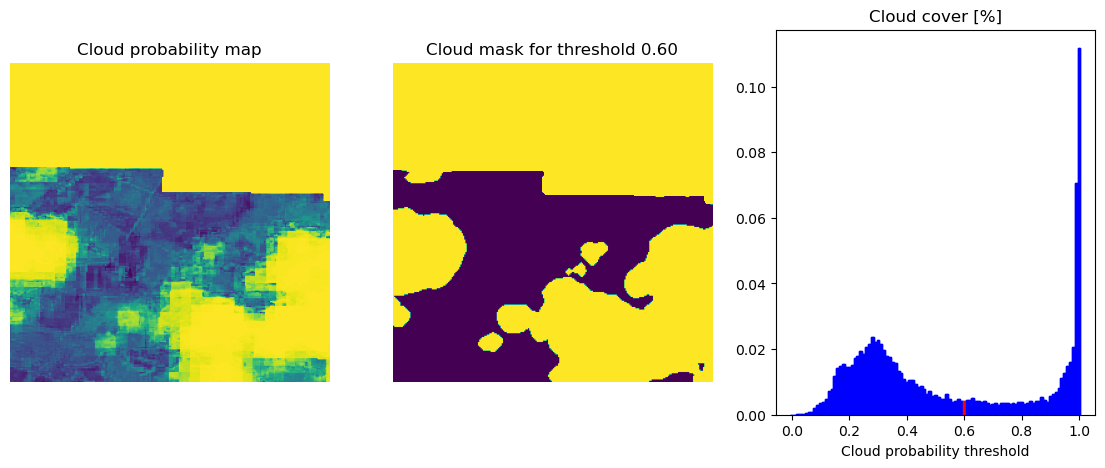

In [24]:
# display(fig_1.canvas, slider_1_widget)
display(fig_1)

In [25]:
plt.close(fig_1)

# Calculate all cloud maps and percentages

In [4]:
from osgeo import gdal
from tqdm import tqdm

In [5]:
from torch.utils.data import Dataset, DataLoader

class CloudMapDataset(Dataset):

    driver = gdal.GetDriverByName("GTiff")
    
    def __init__(self, dataset_manager):
        self.data = dataset_manager.data
        self.cloud_detector = dataset_manager.cloud_detector

    def __getitem__(self, idx):
        
        sample = self.data.iloc[idx]
        s2_reader = gdal.Open(sample["S2"])
        s2_image = s2_reader.ReadAsArray()
        _, rows, cols = s2_image.shape
        
        cloud_map = self.cloud_detector.get_cloud_probability_maps(s2_image)
        
        outdata = self.driver.Create(sample["S2CLOUDMAP"], cols, rows, 1, gdal.GDT_Byte)
        outdata.SetGeoTransform(s2_reader.GetGeoTransform())
        outdata.SetProjection(s2_reader.GetProjection())
        outdata.GetRasterBand(1).WriteArray(cloud_map[0])
        outdata.GetRasterBand(1).SetNoDataValue(255)
        outdata.FlushCache() ##saves to disk!!
        outdata = None
        s2_reader = None

        return

    def __len__(self):
        return len(self.data)

In [6]:
dataset = CloudMapDataset(dataset_manager=dataset_manager)

In [9]:
for i in tqdm(range(len(dataset))):
    _ = dataset[i]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 377964/458790 [8:43:07<1:41:44, 13.24it/s]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 458790/458790 [10:26:46<00:00, 12.20it/s]


# Cloud probability histogram [DEPRECATED]

In [ ]:
# show rows with NaN values
dataset_manager.cloud_histograms

NaN valued come from tiles which were not resampled, thus they are not used in the dataset

In [16]:
dataset_manager.subsets[dataset_manager.subsets.resampled == False]

### Draw example figure

In [17]:
train_dataset_cloud_histogram = dataset_manager.cloud_histograms_subset(split="train").sum(axis=0)
train_dataset_cloud_histogram = train_dataset_cloud_histogram / train_dataset_cloud_histogram.sum()

In [18]:
with plt.ioff():
    fig_2, ax_2 = plt.subplots(figsize=(8, 5))

In [19]:
ax_2.bar(
    left_bin_edges, 
    train_dataset_cloud_histogram, 
    width=1.0 / train_dataset_cloud_histogram.size,
    align="edge",
    color="skyblue",
    edgecolor="steelblue"
)
ax_2.set_ylabel(u"Pixels [%]")
ax_2.set_xlabel("Cloud probability")
ax_2.set_title("Cloud probability histogram for 'train' partition", fontsize=14)

In [20]:
display(fig_2.canvas)
# display(fig_2)

In [21]:
# plt.close(fig_2)

# Cloud-free area based on cloud probability threshold [DEPRECATED]

In [21]:
thresholds = dataset_manager.cloud_probability_bins[1:-1]
thresholds

In [22]:
cloud_free_pixels = (
    dataset_manager
    .cloud_histograms_subset(split="train")
    .dropna(how="any", axis=0)
    .astype(np.int64)
    .cumsum(axis=1)
)

# The last row will always be the total number of pixels, so we drop it since it is useless
assert (cloud_free_pixels.iloc[:, -1] == 256*256).all()
cloud_free_pixels = cloud_free_pixels.iloc[:, :-1]

cloud_free_pixels

In [23]:
# define bin edges that include both 0 and 256*256
cloud_free_histogram_bins = np.arange(start=0, stop=256*(256+1), step=256, dtype=np.int64)  # this includes edges 0 and 256*256
cloud_free_histogram_left_bin_edges = cloud_free_histogram_bins[:-1]
cloud_free_histogram_left_bin_edges_normalized = cloud_free_histogram_left_bin_edges / (256*256)

In [24]:
cloud_free_histogram_left_bin_edges_normalized[224]

In [25]:
# calculate histograms
cloud_free_area_histograms = np.stack(
    [
        np.histogram(
            n_cloudfree_pixels.values,
            bins=cloud_free_histogram_bins
        )[0]  # select only the histogram, not the bins
        for threshold, n_cloudfree_pixels 
        in cloud_free_pixels.items()
    ]
)

cloud_free_area_histograms.shape

In [26]:
cloud_free_area_histograms.max(), cloud_free_area_histograms.shape

In [27]:
# plot
with plt.ioff():
    fig_3, ax_3 = plt.subplots(figsize=(8, 5))

In [28]:
threshold_id = 3

barplot = ax_3.bar(
    x=cloud_free_histogram_left_bin_edges_normalized, 
    height=cloud_free_area_histograms[threshold_id], 
    width=1.0 / cloud_free_area_histograms.shape[1],
    align="edge",
    color="steelblue"
)
ax_3.set_ylabel("N images")
ax_3.set_xlabel("Cloud-free area [%]")
ax_3.set_yscale('log')
ax_3.set_ylim([100, cloud_free_area_histograms.max()*2])
ax_3.set_title(f"Cloud-free images for threshold {thresholds[threshold_id]}", fontsize=14)

# update diagram interactively

slider_3 = widgets.SelectionSlider(
    options=[(f"{threshold:.2f}", i) for i, threshold in enumerate(thresholds)],
    value=threshold_id,
    description='Threshold cloud probability: ',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="auto")
)

def update_im_3(index):
    
    # update cloud mask
    for i, bar in enumerate(barplot):
        bar.set(height=cloud_free_area_histograms[index, i])
    ax_3.set_title(f"Cloud-free images for threshold {thresholds[index]:.2f}", fontsize=14)
    fig_3.canvas.draw_idle()

slider_3_widget = interactive(update_im_3, index=slider_3)

In [29]:
# display(fig_3.canvas, slider_3_widget)
display(fig_3)

In [31]:
# plt.close(fig_3)

### Show histograms for all thresholds

Only display the rightmost part where cloud-free area is 87.5% or more

In [30]:
display_area = 0.875
display_index = np.searchsorted(cloud_free_histogram_left_bin_edges_normalized, display_area)
display_index

In [31]:
with plt.ioff():
    fig_4, ax_4 = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), gridspec_kw={'width_ratios': [20, 1]})

In [32]:
image_4 = ax_4[0].imshow(
    cloud_free_area_histograms[:, display_index:],
    aspect="auto",
    extent=(display_area, 1, 0.95, 0),
    cmap="inferno",
    norm=mpl.colors.LogNorm(
        vmin=cloud_free_area_histograms[:, display_index:].min(), 
        vmax=cloud_free_area_histograms[:, display_index:].max()
    )
)
ax_4[0].set_title("Cloud-free area vs. threshold", fontsize=18)
ax_4[0].set_xlabel("Cloud-free area [%]")
ax_4[0].set_ylabel("Cloud probability threshold [%]")
cbar_4 = fig_4.colorbar(image_4, cax=ax_4[1], ax=ax_4[0], label="Number of images")
fig_4.tight_layout()

In [33]:
display(fig_4.canvas)
# display(fig_4)

In [36]:
# plt.close(fig_4)